# Task 2. Operations of Each Type of Layers

* Requirement: Finished Task 1
* Time to finished: 25 mins
* This file was modified from Caffe 00-classification.ipynb.

We'll introduce layers' operation through calculation with blob, weight, and bias.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [4]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [5]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. Network shape

#### When visualizing a network, there are two different part: 1. Blob 2. Parameter.
* Blobs are the input and output of a layer.
* Parameters include the layer's weight & bias.


#### For each layer, let's look at the blob shapes, which typically have the form (batch_size, channel_dim, height, width).

* Blob shapes of each layer's output

In [123]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(10, 3, 227, 227)
conv1	(10, 96, 55, 55)
pool1	(10, 96, 27, 27)
norm1	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
norm2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
conv4	(10, 384, 13, 13)
conv5	(10, 256, 13, 13)
pool5	(10, 256, 6, 6)
fc6	(10, 4096)
fc7	(10, 4096)
fc8	(10, 1000)
prob	(10, 1000)


#### Look at the parameter shapes. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.
* weights (output_channels, input_channels, filter_height, filter_width)
* biases 1-dimensional shape (output_channels,)

In [124]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + 'weight shape:' + str(param[0].data.shape), '\t' + 'bias shape:' + str(param[1].data.shape)

conv1	weight shape:(96, 3, 11, 11) 	bias shape:(96,)
conv2	weight shape:(256, 48, 5, 5) 	bias shape:(256,)
conv3	weight shape:(384, 256, 3, 3) 	bias shape:(384,)
conv4	weight shape:(384, 192, 3, 3) 	bias shape:(384,)
conv5	weight shape:(256, 192, 3, 3) 	bias shape:(256,)
fc6	weight shape:(4096, 9216) 	bias shape:(4096,)
fc7	weight shape:(4096, 4096) 	bias shape:(4096,)
fc8	weight shape:(1000, 4096) 	bias shape:(1000,)


#### Access the specific layer's parameter

In [125]:
#For example, Here is the conv1 weight
print  net.params['conv1'][0].data

[[[[ -1.21358689e-03   3.23652686e-03   6.70562638e-03 ...,
     -4.04646993e-02  -3.34104374e-02  -2.06615720e-02]
   [ -1.52757822e-03   2.36130832e-03   1.27269002e-02 ...,
     -1.03440229e-02  -1.29766073e-02  -1.19824838e-02]
   [ -1.68795008e-02  -1.96967144e-02  -2.78007202e-02 ...,
      6.51425570e-02   2.69848518e-02   1.14041939e-02]
   ..., 
   [  3.30793811e-03  -1.73901021e-03  -1.38696693e-02 ...,
      1.15031954e-02  -2.62027769e-03  -3.58130375e-04]
   [  1.63359649e-03   3.97288101e-03   5.48139866e-03 ...,
      1.21502439e-02  -1.95710847e-04  -1.42724179e-02]
   [ -8.25322699e-04  -5.14897937e-03  -5.21101989e-03 ...,
      1.21951485e-02   8.27158242e-03  -9.90395527e-03]]

  [[ -6.71558129e-03   1.28365606e-02   2.05077957e-02 ...,
     -3.81963253e-02  -3.59553434e-02  -2.39658169e-02]
   [ -1.53230457e-02  -1.41713768e-02   1.74819166e-03 ...,
      1.00762118e-02  -2.81953742e-03  -8.80346633e-03]
   [ -3.24621275e-02  -4.85872999e-02  -6.45875335e-02 ...,
 

In [126]:
#And also conv1 bias
print  net.params['conv1'][1].data

[-0.50421238 -0.18876393 -0.02636645 -0.28391629 -0.13087654 -0.11392669
 -0.35379818 -0.30511132 -0.29760852 -0.69337481 -0.11503694 -0.61966431
 -0.70348167 -0.36799666 -0.51381624 -0.49909854 -0.39370087 -0.50333488
 -0.49111506 -0.53658897 -0.56017941 -0.76258534 -0.77280825 -0.41975728
  0.03018536 -0.33431506 -0.34035346 -0.02425144 -0.42549044 -0.27354479
 -0.19610897 -0.24530815 -0.21632682 -0.15036488 -0.20419675 -0.34080112
 -0.23292924 -0.39638382 -0.80493212 -0.31510153 -0.58598214 -0.39910233
  0.09619939 -0.08906451 -0.08829892  0.0318777  -0.02993892 -0.6171959
 -0.18537141 -0.53869236 -0.60174769 -0.27657327 -0.50952357 -0.58526754
 -0.63966411 -0.30142948 -0.47553012 -0.43996301 -0.5539273  -0.51534098
 -0.61971736 -0.55452424 -0.40656072 -0.46827394 -0.35246965  0.00648938
 -0.51984924 -0.15539649 -0.5810253  -0.52464545 -0.43813136 -0.07824007
 -0.00753932  0.07540352  0.09931208  0.00120243  0.16252081 -0.24926969
 -0.49946082 -0.26256353 -0.57496488 -0.62123567 -0.

### 4. Operation of layer

* First we load an image into blob to help demonstration. 


In [131]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

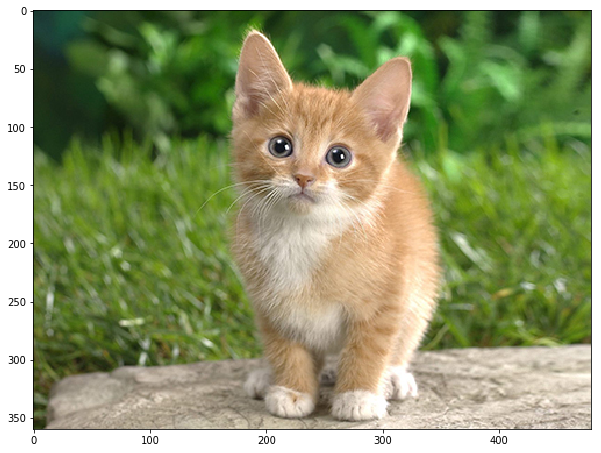

In [132]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [135]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

* Convolution layer

In [159]:
# Remind the concept of convolution, let us first see what value of the conv1 response

print  'Conv1 response shape: ' , net.blobs['conv1'].data.shape
print  'The first value of response: ', net.blobs['conv1'].data[0][0][0][0]

tmp = 0
# 2D convolution , kernel size = 11*11, input 3 channels
for channel2 in range (0,1):
    for channel in range (0,3):
        for num in range(0,11):
            for num2 in range(0,11):
                tmp += net.blobs['data'].data[0][channel][num][num2]*net.params['conv1'][0].data[channel2][channel][num][num2]
            

tmp += net.params['conv1'][1].data[0]
print "Our manual calculate: " ,tmp 


Conv1 response shape:  (10, 96, 55, 55)
The first value of response:  3.17957
Our manual calculate:  3.17956186179


* Activation layer(ReLU)

In [184]:
#ReLU is a nonlinear activation function, if input x<=0 , f(x)=0 , else x>0, f(x)=x

tmp2 = 0
for channel2 in range (0,1):
    for channel in range (0,3):
        for num in range(0,11):
            for num2 in range(0,11):
                #[index + 4] means stride=4, showing the next conv1 output response.
                tmp2 += net.blobs['data'].data[0][channel][num][num2+4]*net.params['conv1'][0].data[channel2][channel][num][num2]
tmp2 += net.params['conv1'][1].data[0]
print 'Before ReLU:' ,tmp2

# But in caffe, we can't see the negative response from blob, because the blob is already transformed to zero.
print 'After ReLU:' ,net.blobs['conv1'].data[0][0][0][1]


 Before ReLU: -4.2275402844
After ReLU: 0.0


* Pooling layer(Maxpooling)

In [249]:
# Pooling layer is used to compress features, for example using Maxpooling and kernel 3*3.
# This means we slide a 3*3 window on features, and only keep the maximum value of them.

print '---The first 9 responses of conv1---'
for num in range (0,3):
    for num2 in range (0,3):
        print net.blobs['conv1'].data[0][0][num][num2]
print '-------------------------------------'


print 'After maxpooling (pool1) layer:' ,net.blobs['pool1'].data[0][0][0][0]

print 'The conv1 output shape:', net.blobs['conv1'].data.shape
print 'pool1: kernel=3*3, stride=2, so the shape become (55-3)/2+1 = 27 '
print 'The pool1 output shape:', net.blobs['pool1'].data.shape

---The first 9 responses of conv1---
3.17957
0.0
0.0
0.0
0.0
0.0
0.0
0.92629
10.3442
-------------------------------------
After maxpooling (pool1) layer: 10.3442
The conv1 output shape: (10, 96, 55, 55)
pool1: kernel=3*3, stride=2, so the shape become (55-3)/2+1 = 27 
The pool1 output shape: (10, 96, 27, 27)


* Fully connected layer

In [218]:
# fully connected means neurons of this layer are connected to all neurons in previous layer 
# Here shows the fc8-layer output.

print net.blobs['fc8'].data[0].shape  # ignore batch index
print net.blobs['fc8'].data[0] # totally 1000 values

(1000,)
[ -5.04316616e+00   4.55470371e+00  -1.82167411e+00  -2.23505187e+00
  -3.33036757e+00  -1.39626908e+00  -1.71295440e+00   9.13079321e-01
   5.24754286e+00  -4.52860147e-01   2.07935262e+00   1.74992013e+00
   4.15723515e+00   5.05818546e-01   1.73996890e+00   1.90342259e+00
   1.85976326e+00   4.20781136e+00  -1.90148187e+00  -3.47886348e+00
  -6.31145060e-01  -1.00252664e+00  -1.58892262e+00  -2.39599371e+00
  -2.69794369e+00  -2.82806635e+00  -1.86897051e+00  -1.42688704e+00
  -2.95923495e+00   3.46339273e+00  -8.02168965e-01  -1.92104197e+00
  -1.12691534e+00  -2.66626167e+00  -2.75435114e+00  -3.62505579e+00
  -2.47259974e+00  -1.57544529e+00  -2.01118326e+00  -1.62947989e+00
  -3.82456064e-01  -1.27296066e+00  -2.67612636e-01  -1.12426138e+00
  -1.18525076e+00  -3.81747270e+00   2.92673141e-01  -3.50600195e+00
  -4.53867435e+00  -4.11362362e+00  -4.62336254e+00   6.96111739e-01
  -3.05434585e+00  -4.84013748e+00  -1.49062109e+00  -3.84650731e+00
  -3.42657542e+00  -4.3518

* Softmax layer

In [241]:
# This layer is used to normalize output response and make sum of them equal to 1 (Like probability).
# Softmax function: y(k) = e^(xk)/(e^(x1) + ... + e^(xn)), n = amount of all elements, k= specific input
print 'Sum of fc8 output:', sum(net.blobs['fc8'].data[0]) 
print 'sum of softmax layer output:', sum(net.blobs['prob'].data[0]) # totally 1000 probs

prob = net.blobs['prob'].data[0]
print 'Maximum probability class:', prob.argmax(), '\t Prob:',max(prob) 


Sum of fc8 output: 1.39082194492
sum of softmax layer output: 1.00000135368
Maximum probability class: 281 	 Prob: 0.312447
